# MAST CAOM Tap Example 

This notebook shows how to use the MAST CAOM Tap service.

### Demonstrated Functionality
* Find MAST CAOM service.
 * Query the NAVO registry using TAP.
 * Display service metadata for use in selecting desired services.
* Search MAST CAOM TAP service for data.
* Download and display data products.


## Imports

In [1]:
import requests
import io
import numpy as np
from astropy.table import Table, unique
from astropy.utils.data import download_file
from astropy.io import fits

# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

# For output using Markdown.
from IPython.display import Markdown, display

# There are a number of relatively unimportant warnings, so suppress them:
import warnings
warnings.filterwarnings("ignore")

## Conveniance Functions

In [2]:
#
# Support for VOTABLEs as astropy tables
#
def aptable_from_votable_response(response):
    """
    Takes a VOTABLE response from a web service and returns an astropy table.
    
    Parameters
    ----------
    response : requests.Response
        Response whose contents are assumed to be a VOTABLE.
        
    Returns
    -------
    astropy.table.Table
        Astropy Table containing the data from the first TABLE in the VOTABLE.
    """
    
    # The astropy table reader would like a file-like object, so convert
    # the response content a byte stream.  This assumes Python 3.x.
    # 
    # (The reader also accepts just a string, but that seems to have two 
    # problems:  It looks for newlines to see if the string is itself a table,
    # and we need to support unicode content.)
    file_like_content = io.BytesIO(response.content)
    
    # The astropy table reader will auto-detect that the content is a VOTABLE
    # and parse it appropriately.
    aptable = Table.read(file_like_content)
    
    # String values in the VOTABLE are stored in the astropy Table as bytes instead 
    # of strings.  To makes accessing them more convenient, we will convert all those
    # bytes values to strings.
    stringify_table(aptable)
    
    return aptable


#
# Wrappers for Virtual Observatory queries
#
def tap_query_sync(query, tap_service, print_url=False):
    """
    Executes the specified TAP query at the specified TAP service and returns
    the result as an astropy Table.
    
    Parameters
    ----------
    query : string
        ADQL (SQL-like) to execute on the given TAP service.
    tap_service : string
        URL endpoint for the desired synchronous TAP service.  This URL will be
        the endpoint for the TAP service identified in the NAVO registry, followed by '/sync'.
    print_url : bool
        Whether or not to print the query URL.  (This only shows the given query URL
        since the other data in the query sent using POST, not GET.)
    
    Returns
    -------
    astropy.table.Table
        An astropy table created from the contents of the VOTABLE response from the TAP query.
           
    """
    tap_params = {
        "request": "doQuery",
        "lang": "ADQL",
        "query": query
    }
    results = requests.post(tap_service+"/sync", data=tap_params)
    if (print_url):
        print('Queried: ' + results.url)
    aptable = aptable_from_votable_response(results)
    return aptable


#
# Functions to help replace bytes with strings in astropy tables that came from VOTABLEs
#
def sval(val):
    """
    Returns a string value for the given object.  When the object is an instanceof bytes,
    utf-8 decoding is used.
    
    Parameters
    ----------
    val : object
        The object to convert
    
    Returns
    -------
    string
        The input value converted (if needed) to a string
    """
    if (isinstance(val, bytes)):
        return str(val, 'utf-8')
    else:
        return str(val)

# Create a version of sval() that operates on a whole column.
svalv = np.vectorize(sval)

def sval_whole_column(single_column):
    """
    Returns a new column whose values are the string versions of the values
    in the input column.  The new column also keeps the metadata from the input column.
    
    Parameters
    ----------
    single_column : astropy.table.Column
        The input column to stringify
        
    Returns
    -------
    astropy.table.Column
        Stringified version of input column
    """
    new_col = svalv(single_column)
    new_col.meta = single_column.meta
    return new_col

def stringify_table(t):
    """
    Substitutes strings for bytes values in the given table.
    
    Parameters
    ----------
    t : astropy.table.Table
        An astropy table assumed to have been created from a VOTABLE.
    
    Returns
    -------
    astropy.table.Table
        The same table as input, but with bytes-valued cells replaced by strings.
    """
    # This mess will look for columns that should be strings and convert them.
    if (len(t) is 0):
        return   # Nothing to convert
    
    scols = []
    for col in t.columns:
        colobj = t.columns[col]
        if (colobj.dtype == 'object' and isinstance(t[colobj.name][0], bytes)):
            scols.append(colobj.name)

    for colname in scols:
        t[colname] = sval_whole_column(t[colname])
        

## Find the MAST caomTap service

Perform a registry query to find the access url for the MAST CAOM Tap service.

In [3]:
#
# Perform a synchronous TAP query on the NAVO registry to find Simple Image Access
# services from MAST.
#
tap_service_url = "https://vao.stsci.edu/RegTAP/TapService.aspx"
query = """
    select b.waveband,b.short_name,a.ivoid,b.res_description,c.access_url,b.reference_url from rr.capability a 
    natural join rr.resource b 
    natural join rr.interface c
    where b.short_name like '%CAOMTAP' and a.standard_id = 'ivo://ivoa.net/std/tap'
    order by short_name
"""
results = tap_query_sync(query, tap_service_url)

# Display results in a readable way including the 
# short_name, ivoid, res_description and reference_url.
for row in results:
    md = '### {} ({})'.format(row['short_name'], row['ivoid'])
    display(Markdown(md))
    print('Access URL:',row['access_url'])
    print(row['res_description'])
    print('(More info: {})'.format(row['reference_url']))

### STScI CAOMTAP (ivo://archive.stsci.edu/caomtap)

Access URL: http://vao.stsci.edu/CAOMTAP/TapService.aspx
The MAST Archive at STScI TAP end point for observational data, saved in the Common Archive Data Model format and made available through the ObsCore limited view. The Table Access Protocol (TAP) lets you execute queries against our database tables, and inspect various metadata. Upload is not currently supported. Tables exposed through this endpoint include the ObsCore (version 1.1) view of our CAOM (version 2.0) database, as well as all other CAOM tables
(More info: http://vao.stsci.edu/CAOMTAP/querymanager.html)


In [4]:
caomTapAccessUrl = results[0]['access_url']

## See what tables are available

In [5]:
tableQuery = """
    SELECT
    *
    FROM tap_schema.tables
    """

caomTables = tap_query_sync(tableQuery, caomTapAccessUrl)

caomTables

utype,description,table_type,table_name,schema_name
str2,str271,str5,str26,str10
,,table,tap_schema.schemas,tap_schema
,,table,tap_schema.tables,tap_schema
,,table,tap_schema.columns,tap_schema
,,table,tap_schema.keys,tap_schema
,,table,tap_schema.key_columns,tap_schema
,"The IVOA-defined obscore table, version 1.0, containing generic metadata for datasets within this datacenter's CAOM database.",view,ivoa.obscore,ivoa
,An observation is the primary top-level class for empirical data.,table,dbo.CaomObservation,dbo
,A plane is one (of several) data product(s) that are created as part of an observation. Each simple observation typically has one raw plane created by the observing process itself and may have one or more additional planes that are produced by subsequent data processing.,table,dbo.CaomPlane,dbo
,An artifact is one physical product or resource (typically a file) that is part of a plane.,table,dbo.CaomArtifact,dbo


## Basic cone search

A basic cone search in the **ivoa.obscore** table.  
The **ivoa.obscore** table is defined by the IVOA and contains a minimal set of common parameters for each data product.

In [6]:
query = """
    SELECT
    TOP 1000
    *
    FROM ivoa.obscore
    WHERE 
       1=CONTAINS(POINT('ICRS', s_ra, s_dec),
                  CIRCLE('ICRS', 189.2, 62.21, 0.05 ))
    """

results = tap_query_sync(query, caomTapAccessUrl)

print(results[:10])

dataproduct_type calib_level obs_collection ... facility_name instrument_name
---------------- ----------- -------------- ... ------------- ---------------
           image           2            HLA ...                       ACS/WFC
        spectrum           2            HST ...         STScI         ACS/WFC
           image           2            HLA ...                     WFC3/UVIS
           image           2            HLA ...                       WFC3/IR
        spectrum           3            HLA ...                       ACS/WFC
           image           1            HST ...         STScI       WFC3/UVIS
        spectrum           1            HST ...         STScI        STIS/CCD
           image           2            HST ...         STScI         ACS/WFC
        spectrum           2            HST ...         STScI         ACS/WFC
           image           2            HLA ...                       ACS/WFC


## CAOM cone search 

This cone search is somewhat similar to searching for MAST observations in the <a href="https://mast.stsci.edu">MAST Discovery Portal</a>.

CAOM stands for Common Access Archive Model, a general purpose data model for use as the core data model of an astronomical data centre. MAST is one of the archives that uses this model.

The search below performs a cone search and returns a number of the most commonly used data columns

In [7]:
query = """
    SELECT TOP 1000
        plane.dataProductType,plane.calibrationLevel,
        obs.collection,obs.observationID,obs.trgName,
        plane.posLocationRA, plane.posLocationDec, plane.timMin, plane.timMax, plane.timExposure,
        plane.enrEMBand, plane.enrBandpassName, plane.enrMin, plane.enrMax,
        obs.trgType, obs.trgKeywords, obs.prpTitle, 
        plane.dataRelease, plane.dataRights,
        obs.trgMoving, obs.insName, obs.prpPI, obs.prpID, obs.intentType, obs.prpProject,
        plane.previewURI, plane.productURI, plane.obsID, plane.planeID, plane.productID

    FROM dbo.CaomPlane AS plane, dbo.CaomObservation AS obs
    WHERE 
        plane.obsID = obs.obsID
        AND
        1=CONTAINS(POINT('ICRS', plane.posLocationRA, plane.posLocationDec),
                   CIRCLE('ICRS', 189.2, 62.21, 0 ))
    """
results = tap_query_sync(query, caomTapAccessUrl)
results.show_in_notebook(display_length=10)

idx,dataProductType,calibrationLevel,collection,observationID,trgName,posLocationRA,posLocationDec,timMin,timMax,timExposure,enrEMBand,enrBandpassName,enrMin,enrMax,trgType,trgKeywords,prpTitle,dataRelease,dataRights,trgMoving,insName,prpPI,prpID,intentType,prpProject,previewURI,productURI,obsID,planeID,productID
0,image,2,HLA,hst_10339_e5_acs_wfc_f850lp_03,HDF-NORTH-GOODS-TILE-TILT-5,189.21129535740201,62.184059388537101,53472.886550000003,53472.891479999998,425.0,OPTICAL,F850LP,850.0,940.0,,"ra=189.21129536, dec= 62.18405939",,4/13/2005 3:38:33 AM,PUBLIC,--,ACS/WFC,Riess,10339,science,HLA,https://hla.stsci.edu/cgi-bin/preview.cgi?dataset=hst_10339_e5_acs_wfc_f850lp_03,,2007144928,2017581844,hst_10339_e5_acs_wfc_f850lp_03
1,image,1,HST,IBTMAJBXQ,GOODSN-ORI090-VAJ,189.24874138909999,62.207004976,56513.294289999998,56513.299319999998,434.0,OPTICAL,F350LP,325.5,993.79998779296898,GALAXY;HIGH REDSHIFT GALAXY,"ra=189.24874139, dec= 62.20700498","Cosmic Assembly Near-IR Deep Extragalactic Legacy Survey -- GOODS-North Field, Late Visits of SNe Search",8/10/2013 12:37:25 PM,PUBLIC,--,WFC3/UVIS,Faber,12445,science,GO,mast:HST/product/ibtmajbxq/ibtmajbxq_trl.fits,mast:HST/product/ibtmajbxq/ibtmajbxq_trl.fits,2002933772,2010546924,IBTMAJBXQ
2,image,1,HST,J91WB7ILQ,HDF-NORTH-GOODS-TILE-NORM-7,189.14745833329999,62.200847222219998,53332.676379999997,53332.699639999999,1540.0,OPTICAL,F850LP,850.0,940.0,BLANK FIELD;HIGH LATITUDE FIELD;UNIDENTIFIED,"ra=189.14745833, dec= 62.20084722",PANS,11/23/2004 7:13:06 PM,PUBLIC,--,ACS/WFC,Riess,10339,science,GO,mast:HST/product/j91wb7ilq/j91wb7ilq_raw.fits,mast:HST/product/j91wb7ilq/j91wb7ilq_raw.fits,2003072458,2010685610,J91WB7ILQ
3,image,3,HLA,hst_12445_ae_wfc3_ir_total,GOODSN-ORI090-VAE,189.19034355807401,62.193914667628803,56511.203070000003,56511.232559999997,2361.739,,DETECTION,--,--,,"ra=189.19034356, dec= 62.19391467",,8/7/2013 9:01:21 AM,PUBLIC,--,WFC3/IR,Faber,12445,science,HLA,https://hla.stsci.edu/cgi-bin/preview.cgi?dataset=hst_12445_ae_wfc3_ir_total,,2007557831,2017994747,hst_12445_ae_wfc3_ir_total
4,image,3,HLA,HST_7235_14_NIC_NIC3_total,HDF-123645+621214,189.192071860933,62.203871750636999,50840.411740000003,50840.764280000003,13439.4,,DETECTION,--,--,,"ra=189.19207186, dec= 62.20387175",,1/27/1999 10:29:28 PM,PUBLIC,--,NICMOS/NIC3,Thompson,7235,science,HLA,https://hla.stsci.edu/cgi-bin/preview.cgi?dataset=HST_7235_14_NIC_NIC3_total,,2007572653,2018009569,HST_7235_14_NIC_NIC3_total
5,image,3,HST,U31P070OT,HDF-123649+621346,189.2024514407,62.21718355302,50076.964090000001,50076.97913,1300.0,OPTICAL,F606W,510.89001464843801,661.13000488281295,BLANK FIELD;HIGH LATITUDE FIELD;UNIDENTIFIED,"ra=189.20245144, dec= 62.21718355",THE HUBBLE DEEP FIELD,1/15/1996 4:15:00 PM,PUBLIC,--,WFPC2/WFC,Williams,6337,science,GO/DD,mast:HST/product/u31p070ot/u31p070ot_drz.fits,mast:HST/product/u31p070ot/u31p070ot_drz.fits,2003613041,2012785107,U31P070OT
6,image,3,HST,U31P0804T,HDF-123649+621346,189.2024514407,62.21718355302,50078.07172,50078.084459999998,1100.0,OPTICAL,F450W,400.82000732421898,495.89999389648398,BLANK FIELD;HIGH LATITUDE FIELD;UNIDENTIFIED,"ra=189.20245144, dec= 62.21718355",THE HUBBLE DEEP FIELD,1/15/1996 4:15:00 PM,PUBLIC,--,WFPC2/WFC,Williams,6337,science,GO/DD,mast:HST/product/u31p0804t/u31p0804t_drz.fits,mast:HST/product/u31p0804t/u31p0804t_drz.fits,2003613092,2012785156,U31P0804T
7,image,2,HLA,hst_08389_05_wfpc2_f606w_wf_06,HDF-123649+621346,189.2017635309,62.217623104589997,51886.103620000002,51886.118670000003,1300.0,OPTICAL,F606W,510.89001464843801,661.13000488281295,,"ra=189.20176353, dec= 62.21762310",,12/8/2001 2:45:50 PM,PUBLIC,--,WFPC2/WFC,IBATA,8389,science,HLA,https://hla.stsci.edu/cgi-bin/preview.cgi?dataset=hst_08389_05_wfpc2_f606w_wf_06,,2007045063,2017481979,hst_08389_05_wfpc2_f606w_wf_06
8,image,2,HST,JBVVBKRSQ,BIAS,189.0212233236,62.168375189019997,56021.207009999998,56021.206910000001,0.0,OPTICAL,F502N;F660N,499.39999389648398,505.0,,"ra=189.02122332, dec= 62.16837519"

## Downloading Data

The MAST download service url: **mast.stsci.edu/portal/download/file/?uri=**

Simply provide this service the data URI for download.

In [8]:
mastDownloadService = "https://mast.stsci.edu/portal/download/file/?uri=" 

localPaths = []

for observation in results[:10]:
    if not observation["productURI"]:
        continue
    downloadURL = mastDownloadService + observation["productURI"]
    localPaths.append(download_file(downloadURL))

## Viewing Data

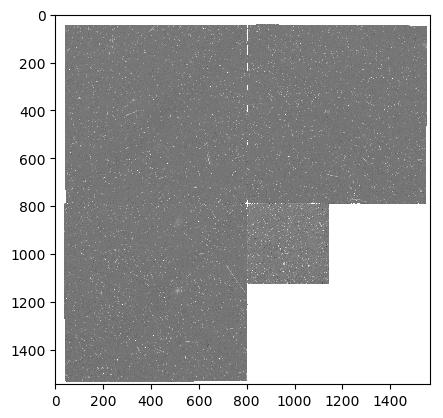

In [9]:
image = fits.getdata(localPaths[3])
plt.imshow(image, cmap='gray', norm=LogNorm())